In [1]:
# import necessary libraries 

import argparse
import numpy as np
import pandas as pd
import re
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scienceplots
from matplotlib.cm import get_cmap
from astropy.coordinates import SkyCoord
import astropy.units as u


In [2]:
#Load the data
file_path = "GRB_Summary_table.txt"   # Update this if needed with your path
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
df.columns = [
    "GRB_Name", "Trigger", "Trigger_Time", "RA_deg", "Dec_deg", "pos_err", "duration",
    "col7", "col8", "col9", "col10", "z", "col12", "col13", "col14"
] ## name those as required for your work



/tmp/ipykernel_101994/1301966550.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


In [3]:
ra = df["RA_deg"].to_numpy(dtype=float)
dec = df["Dec_deg"].to_numpy(dtype=float)
pos_err = df["pos_err"].to_numpy(dtype=float)
duration = df["duration"].to_numpy(dtype=float)
z = df["z"].to_numpy(dtype=float)
mask = np.isfinite(ra) & np.isfinite(dec) & (ra != -999) & (dec != -999)
ra, dec = ra[mask], dec[mask]
# mask the other parameters as needed
pos_err = pos_err[mask]
duration = duration[mask]
z = z[mask]
# filter out the invalid duration values
valid_duration_mask = np.isfinite(duration) & (duration != -999)
ra = ra[valid_duration_mask]
dec = dec[valid_duration_mask]
pos_err = pos_err[valid_duration_mask]
duration = duration[valid_duration_mask]
z = z[valid_duration_mask]

# filter out the invalid pos_err values
valid_pos_err_mask = np.isfinite(pos_err) & (pos_err != -999)
ra = ra[valid_pos_err_mask]
dec = dec[valid_pos_err_mask]
pos_err = pos_err[valid_pos_err_mask]
duration = duration[valid_pos_err_mask]
z = z[valid_pos_err_mask]   
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
x = (360.0 * u.deg - coords.ra).wrap_at(180 * u.deg).radian
y = coords.dec.radian

# separate short and long GRBs
short_mask = duration <= 2.0
long_mask = duration > 2.0
x_short, y_short = x[short_mask], y[short_mask]
x_long, y_long = x[long_mask], y[long_mask]
print(len(x_short), len(x_long))
pos_err_short = pos_err[short_mask]
pos_err_long = pos_err[long_mask]
z_short = z[short_mask]
z_long = z[long_mask]


1268 6277


Fit parameters (A1, mu1, sigma1, A2, mu2, sigma2):
[2.26801755e+02 8.24762301e-02 7.18126592e-01 6.12245503e+02
 1.51106304e+00 4.56912019e-01]


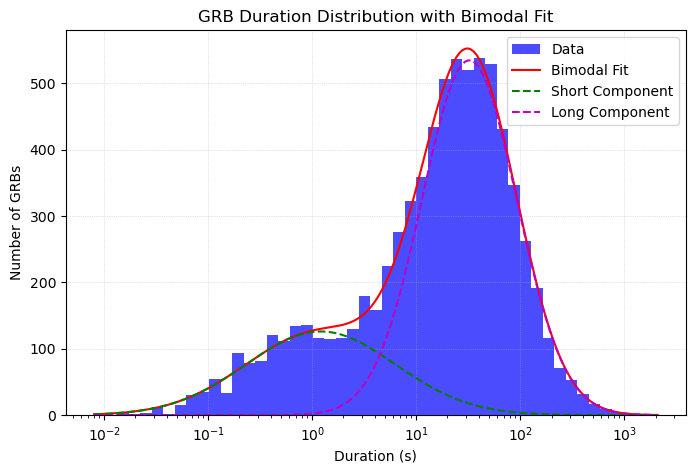

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import norm

# plot the duration distribution in log scale for the duration axis
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

# Create log-spaced bins from the minimum to the maximum duration value
bins = np.logspace(np.log10(duration.min()), np.log10(duration.max()), 50)
# Calculate histogram
counts, bin_edges = np.histogram(duration, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram using the pre-calculated values
ax.hist(duration, bins=bins, color="blue", alpha=0.7, label="Data")

# Define the bimodal Gaussian function (sum of two Gaussians)
def bimodal_log(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * norm.pdf(np.log10(x), mu1, sigma1) +
            A2 * norm.pdf(np.log10(x), mu2, sigma2))

# Initial guesses for the parameters
# Based on the visual separation of short (<2s) and long (>2s) GRBs
p0 = [
    len(x_short), np.log10(0.3), 0.5,  # A1, mu1, sigma1 for short GRBs
    len(x_long), np.log10(30), 0.5    # A2, mu2, sigma2 for long GRBs
]

# Fit the bimodal function to the histogram data
# We use the log of bin_centers for the x-data in the fit function
try:
    popt, pcov = curve_fit(bimodal_log, bin_centers, counts, p0=p0)
    
    # Plot the fitted curve
    x_fit = np.logspace(np.log10(duration.min()), np.log10(duration.max()), 200)
    y_fit = bimodal_log(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label='Bimodal Fit')

    # Plot individual components of the fit
    y_fit1 = popt[0] * norm.pdf(np.log10(x_fit), popt[1], popt[2])
    y_fit2 = popt[3] * norm.pdf(np.log10(x_fit), popt[4], popt[5])
    ax.plot(x_fit, y_fit1, 'g--', label='Short Component')
    ax.plot(x_fit, y_fit2, 'm--', label='Long Component')
    
    print("Fit parameters (A1, mu1, sigma1, A2, mu2, sigma2):")
    print(popt)

except RuntimeError:
    print("Fit failed. Could not find optimal parameters.")


ax.set_xscale("log")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Number of GRBs")
ax.set_title("GRB Duration Distribution with Bimodal Fit")
ax.legend()
plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
plt.show()


Gamma fit parameters: a=1.4854929871004634, loc=0, scale=1.2987770278421298


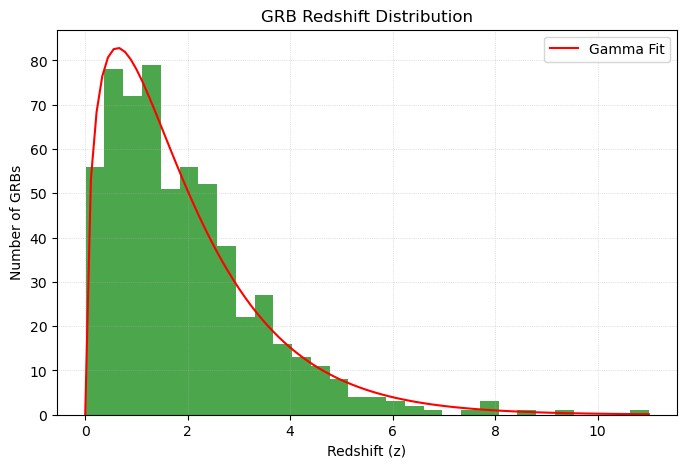

In [5]:
# plot the redshift distribution for all GRBs
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
# filter out invalid redshift values
valid_z_mask = np.isfinite(z) & (z != -999)
z_valid = z[valid_z_mask]
ax.hist(z_valid, bins=30, color="green", alpha=0.7)
ax.set_xlabel("Redshift (z)")
ax.set_ylabel("Number of GRBs")
ax.set_title("GRB Redshift Distribution")
# fit a gamma distribution to the redshift data
from scipy.stats import gamma
a, loc, scale = gamma.fit(z_valid, floc=0)  # fix location to 0
x_fit = np.linspace(0, z_valid.max(), 100)
y_fit = gamma.pdf(x_fit, a, loc=loc, scale=scale) * len(z_valid) * (z_valid.max() / 30)  # scale to histogram
# print the fit parameters
print(f"Gamma fit parameters: a={a}, loc={loc}, scale={scale}")
ax.plot(x_fit, y_fit, 'r-', label='Gamma Fit')
ax.legend()
plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
plt.show()

In [6]:

import astropy.units as u   # this is the units object, keep the name 'u' for units only

# generate the GRBs with the assumption of isotropic distribution for positions,
# and the same redshift distribution as observed and the duration distribution as observed
num_simulated_grbs = (x_short.size + x_long.size)*10
print(f"Generating {num_simulated_grbs} simulated GRBs.")

# isotropic distribution for positions on the sphere:
# l ~ Uniform(0, 2π), sin(b) ~ Uniform(-1, 1)
u_rand = np.random.uniform(0.0, 1.0, num_simulated_grbs)
v_rand = np.random.uniform(0.0, 1.0, num_simulated_grbs)

# galactic coordinates (in radians, as plain floats)
l_rad = 2.0 * np.pi * v_rand                  # [0, 2π)
b_rad = np.arcsin(2.0 * u_rand - 1.0)         # [-π/2, π/2]

# convert to ICRS (RA, Dec) – here we attach units exactly once
sim_coords = SkyCoord(l=l_rad * u.rad, b=b_rad * u.rad, frame="galactic").icrs

# calculate x and y for mollweide projection
# RA: wrap at 180 deg, in radians; Dec directly in radians
sim_x = sim_coords.ra.wrap_at(180 * u.deg).radian
sim_y = sim_coords.dec.radian

# redshift distribution from the fitted gamma distribution
sim_z = gamma.rvs(a, loc=loc, scale=scale, size=num_simulated_grbs)

# duration distribution from the fitted bimodal distribution
num_short = int(num_simulated_grbs * (len(x_short) / (len(x_short) + len(x_long))))
num_long = num_simulated_grbs - num_short

# The bimodal fit was performed on log10(duration),
# so we generate from a normal distribution and exponentiate base 10.
sim_duration_short = 10.0 ** np.random.normal(popt[1], popt[2], num_short)
sim_duration_long  = 10.0 ** np.random.normal(popt[4], popt[5], num_long)
sim_duration = np.concatenate([sim_duration_short, sim_duration_long])
np.random.shuffle(sim_duration)

# turn simulated results into a .txt file
sim_data = np.column_stack((sim_x, sim_y, sim_z, sim_duration))
np.savetxt("simulated_grbs.txt", sim_data, header="ra decl redshift T90")

Generating 75450 simulated GRBs.


Text(0.5, 1.0, 'Simulated GRB Redshift Distribution')

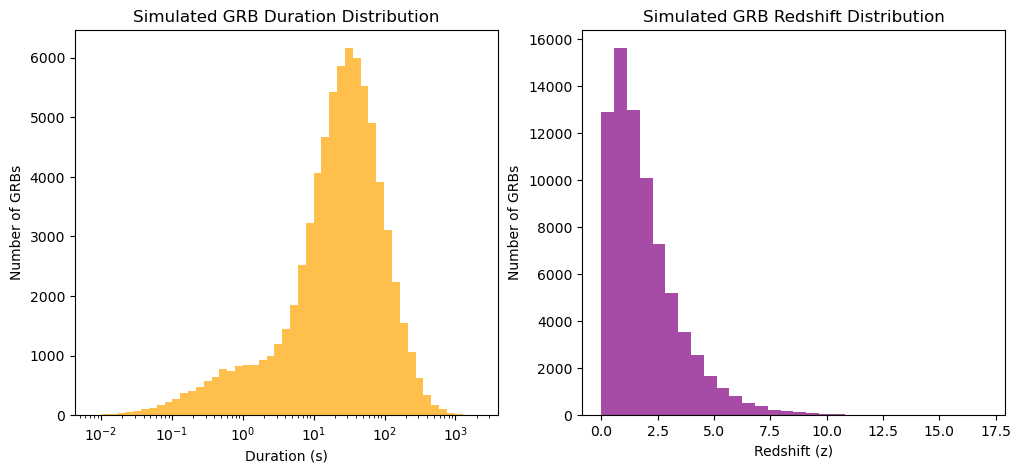

In [7]:
# plot the histograms of the simulated data to compare with the observed data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# duration histogram
axs[0].hist(sim_duration, bins=bins, color="orange", alpha=0.7)
axs[0].set_xscale("log")
axs[0].set_xlabel("Duration (s)")
axs[0].set_ylabel("Number of GRBs")
axs[0].set_title("Simulated GRB Duration Distribution")
# redshift histogram
axs[1].hist(sim_z, bins=30, color="purple", alpha=0.7)
axs[1].set_xlabel("Redshift (z)")
axs[1].set_ylabel("Number of GRBs")
axs[1].set_title("Simulated GRB Redshift Distribution")

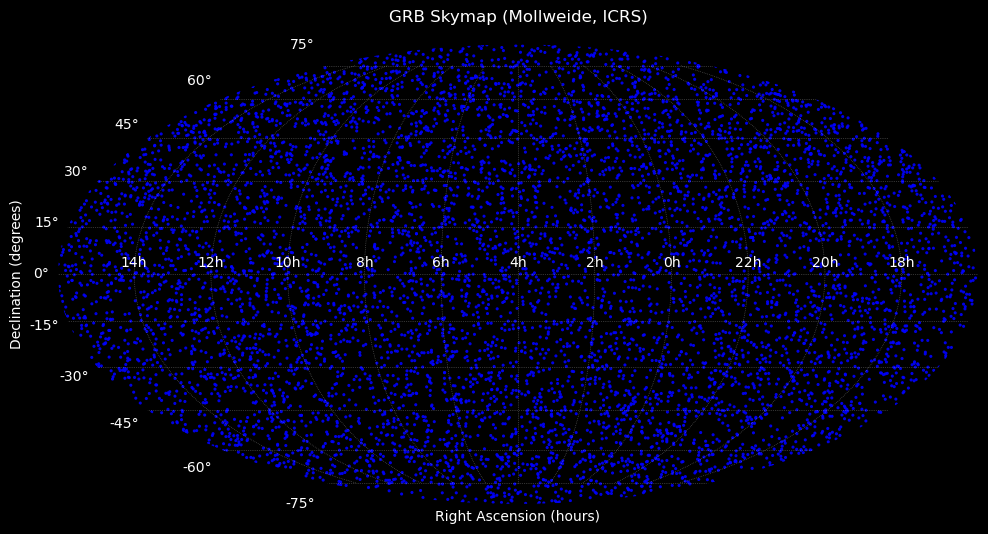

In [8]:
fig = plt.figure(figsize=(10, 6), facecolor="black")
ax = fig.add_subplot(111, projection="mollweide", facecolor="black")
ax.scatter(x, y, s=5, color="blue", alpha=0.9, edgecolors="none")
ax.grid(True, linestyle=":", linewidth=0.5, color="white", alpha=0.4)
ax.tick_params(colors="white")

xticks = np.radians(np.linspace(-150, 150, 11))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{h}h" for h in [14,12,10,8,6,4,2,0,22,20,18]], color="white")

ax.set_xlabel("Right Ascension (hours)", color="white")
ax.set_ylabel("Declination (degrees)", color="white")
ax.set_title("GRB Skymap (Mollweide, ICRS)", color="white", pad=16)

plt.tight_layout()
#plt.savefig("GRB_Skymap_from_SummaryTable.png", dpi=300, bbox_inches="tight", facecolor="black")
plt.show()


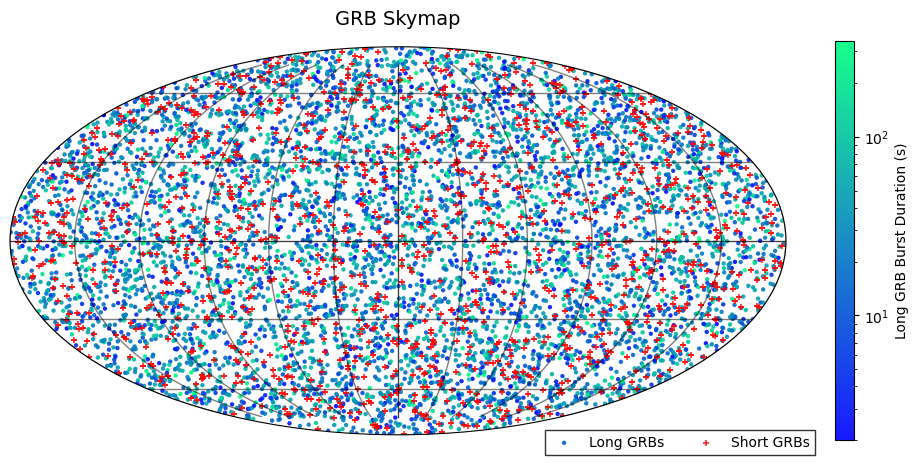

In [9]:
# import the lognorm
from matplotlib.colors import LogNorm

# Create a shared normalization object
# Combine long-duration GRBs (real + simulated)
all_durations = np.concatenate([duration[long_mask], sim_duration[num_short:]])

# Compute 1st and 99th percentiles
vmax = np.percentile(all_durations, 99)

# Create shared normalization, trimming the extremes
shared_norm = LogNorm(vmin=2, vmax=vmax)
# plot the short and long GRBs separately
fig = plt.figure(figsize=(10, 6), facecolor="white")
ax = fig.add_subplot(111, projection="mollweide", facecolor="white")

sc = ax.scatter(x_long, y_long, s=10, c=duration[long_mask],
           marker="o", cmap="winter", norm=shared_norm,
           alpha=0.9, edgecolors="none", label="Long GRBs")
ax.scatter(x_short, y_short, s=18, color="red", marker="+", linewidths=1.1, alpha=0.9,
           label="Short GRBs")

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", pad=0.05, shrink=0.7)
cbar.set_label("Long GRB Burst Duration (s)", color="black")
cbar.ax.yaxis.set_tick_params(color="black")
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

ax.grid(True, linestyle=":", linewidth=0.5, color="white", alpha=0.4)
ax.tick_params(colors="black")
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_xlabel("Right Ascension", color="black")
#ax.set_ylabel("Declination", color="black")
xticks = np.radians(np.linspace(-150, 150, 11))
ax.set_xticks(xticks)

ax.grid(True, linestyle="-", linewidth=1, color="black", alpha=0.5)
ax.set_xticks(np.radians(np.linspace(-180, 180, 13)))  # Fewer longitude lines
ax.set_yticks(np.radians(np.linspace(-90, 90, 7)))    # Fewer latitude lines
ax.axhline(y=0, color="black", linewidth=0.8, linestyle="-", alpha=0.5)  # Equator
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-", alpha=0.5)  # Prime meridian

# ax.set_xticklabels([f"{h}h" for h in [14,12,10,8,6,4,2,0,22,20,18]], color="black")
# ax.set_xlabel("Right Ascension (hours)", color="black")
# ax.set_ylabel("Declination (degrees)", color="black")
ax.set_title("GRB Skymap", color="black", pad=16, fontsize=14)
legend = ax.legend(loc='lower left', bbox_to_anchor=(0.68, -0.07),
                   ncol=2, fancybox=False, 
                   facecolor="white", edgecolor="black", labelcolor="black")
for text in legend.get_texts():
    text.set_color("black")
plt.tight_layout()
plt.savefig("GRB_skymap_with_duration_colorbar.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig('GRBskymap.pdf', bbox_inches='tight')
plt.show()

# Make the longitude and latitude lines more fewer and make sure it extends to the poles